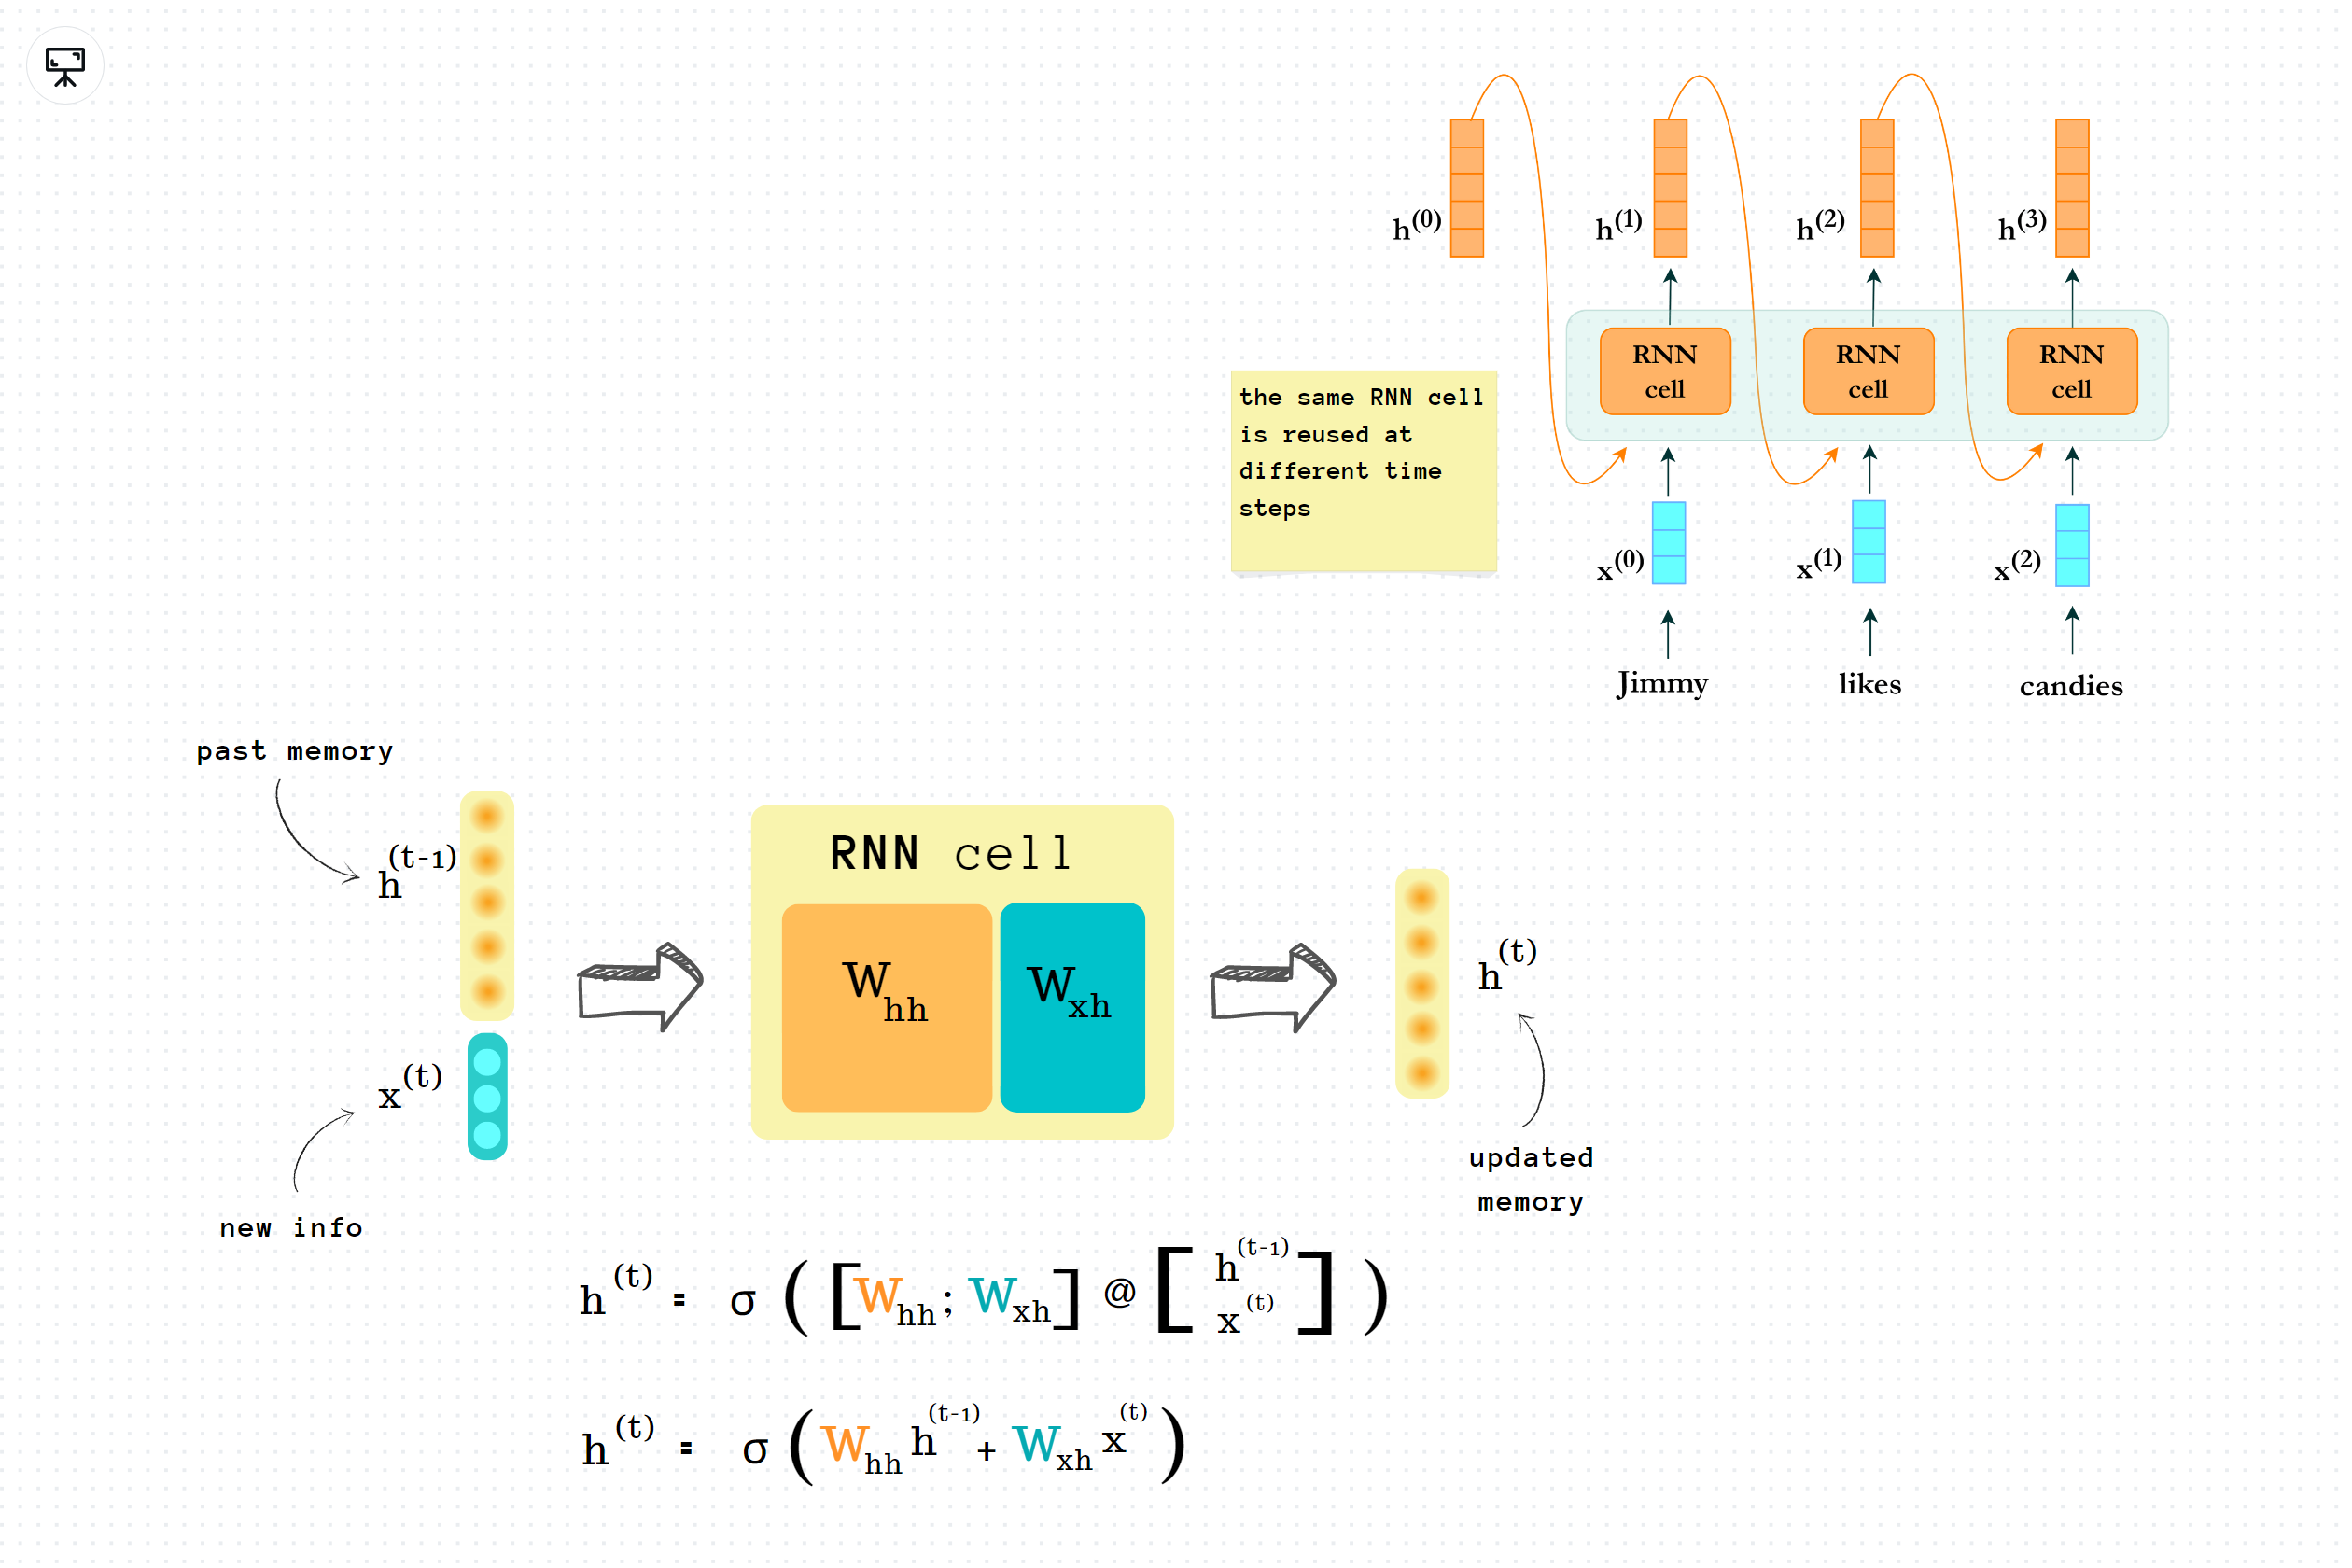

In [8]:
sentence = "Jimmy likes candies"
vocabulary = {"Jimmy":0, "likes":1, "candies":2}
indices = torch.LongTensor([vocabulary[word] for word in sentence.split()]) 
embedding_layer = nn.Embedding(num_embeddings = len(indices), embedding_dim=3)
sequence = embedding_layer(indices)
sequence.size()

torch.Size([3, 3])

## <h6 style="text-align: center;"><b>Initialize Recurrent Layer</b>

In [4]:
import torch
import torch.nn as nn

rnn_layer = nn.RNN(input_size = 3,               # dimentionality of input tensor 
                   hidden_size = 5,              # number of features in the hidden state h
                   batch_first = True)           # input/output size: (batch_size, seq_len, nfeature) 

W_hh = rnn_layer.weight_hh_l0
W_xh = rnn_layer.weight_ih_l0
bias_hh = rnn_layer.bias_hh_l0
bias_xh = rnn_layer.bias_ih_l0

print("W_hh shape", W_hh.size())
print("W_xh shape", W_xh.size())
print("bias_xh shape", bias_xh.size())
print("bias_hh shape", bias_hh.size())

W_hh shape torch.Size([5, 5])
W_xh shape torch.Size([5, 3])
bias_xh shape torch.Size([5])
bias_hh shape torch.Size([5])


In [6]:
# create initial hidden state 
hidden_zero = torch.zeros(1, 5) # h0

In [9]:
# compute sequence representation with RNN
rnn_output, last_hidden = rnn_layer(sequence, hidden_zero)

print(f"RNN output with size {rnn_output.size()}:\n")
for t, h_t in enumerate(rnn_output.detach()):
    print(f"      h{t+1}: ", h_t)
print()
print(f"RNN last hidden state with size {last_hidden.size()}: \n")
print(f"      h3: ", last_hidden.detach())

RNN output with size torch.Size([3, 5]):

      h1:  tensor([-0.2049,  0.4324, -0.7147,  0.0087, -0.3411])
      h2:  tensor([-0.4423, -0.7449, -0.1573,  0.0400,  0.8793])
      h3:  tensor([ 0.0738, -0.4879,  0.1307, -0.0240,  0.3772])

RNN last hidden state with size torch.Size([1, 5]): 

      h3:  tensor([[ 0.0738, -0.4879,  0.1307, -0.0240,  0.3772]])


## <h6 style="text-align: center;"><b>Manual forward RNN Layer</b>

In [10]:
outputs = []

for t, word in enumerate(sequence):
    xt = word.view(1, -1)  #  (embed_dim) -> (1, embed_dim)
    
    print(f"Time step {t} =>")
    print(f"Input word ({sentence.split()[t]}) :", xt.detach().numpy())
    if t > 0:
        prev_h = outputs[-1]
    else:
        prev_h = hidden_zero
        
    # ((1, 3) @ (3, 5) + (1, 5)) + ((1, 3) @ (3, 5) + (1, 5))
    ht = torch.tanh((xt @ W_xh.T + bias_xh) + (prev_h @ W_hh.T + bias_hh))
    print("RNN output: ", ht.detach().numpy())
    outputs.append(ht.detach())

Time step 0 =>
Input word (Jimmy) : [[-0.17937043  1.1374078   0.6648245 ]]
RNN output:  [[-0.2048638   0.43244895 -0.71470106  0.00874732 -0.34105903]]
Time step 1 =>
Input word (likes) : [[ 1.2699927  -1.7592111   0.42966068]]
RNN output:  [[-0.44226524 -0.74489677 -0.1573339   0.0400172   0.8792588 ]]
Time step 2 =>
Input word (candies) : [[ 1.2774642  -0.31476068 -0.99697274]]
RNN output:  [[ 0.07379518 -0.48788553  0.13069974 -0.02398144  0.37719092]]


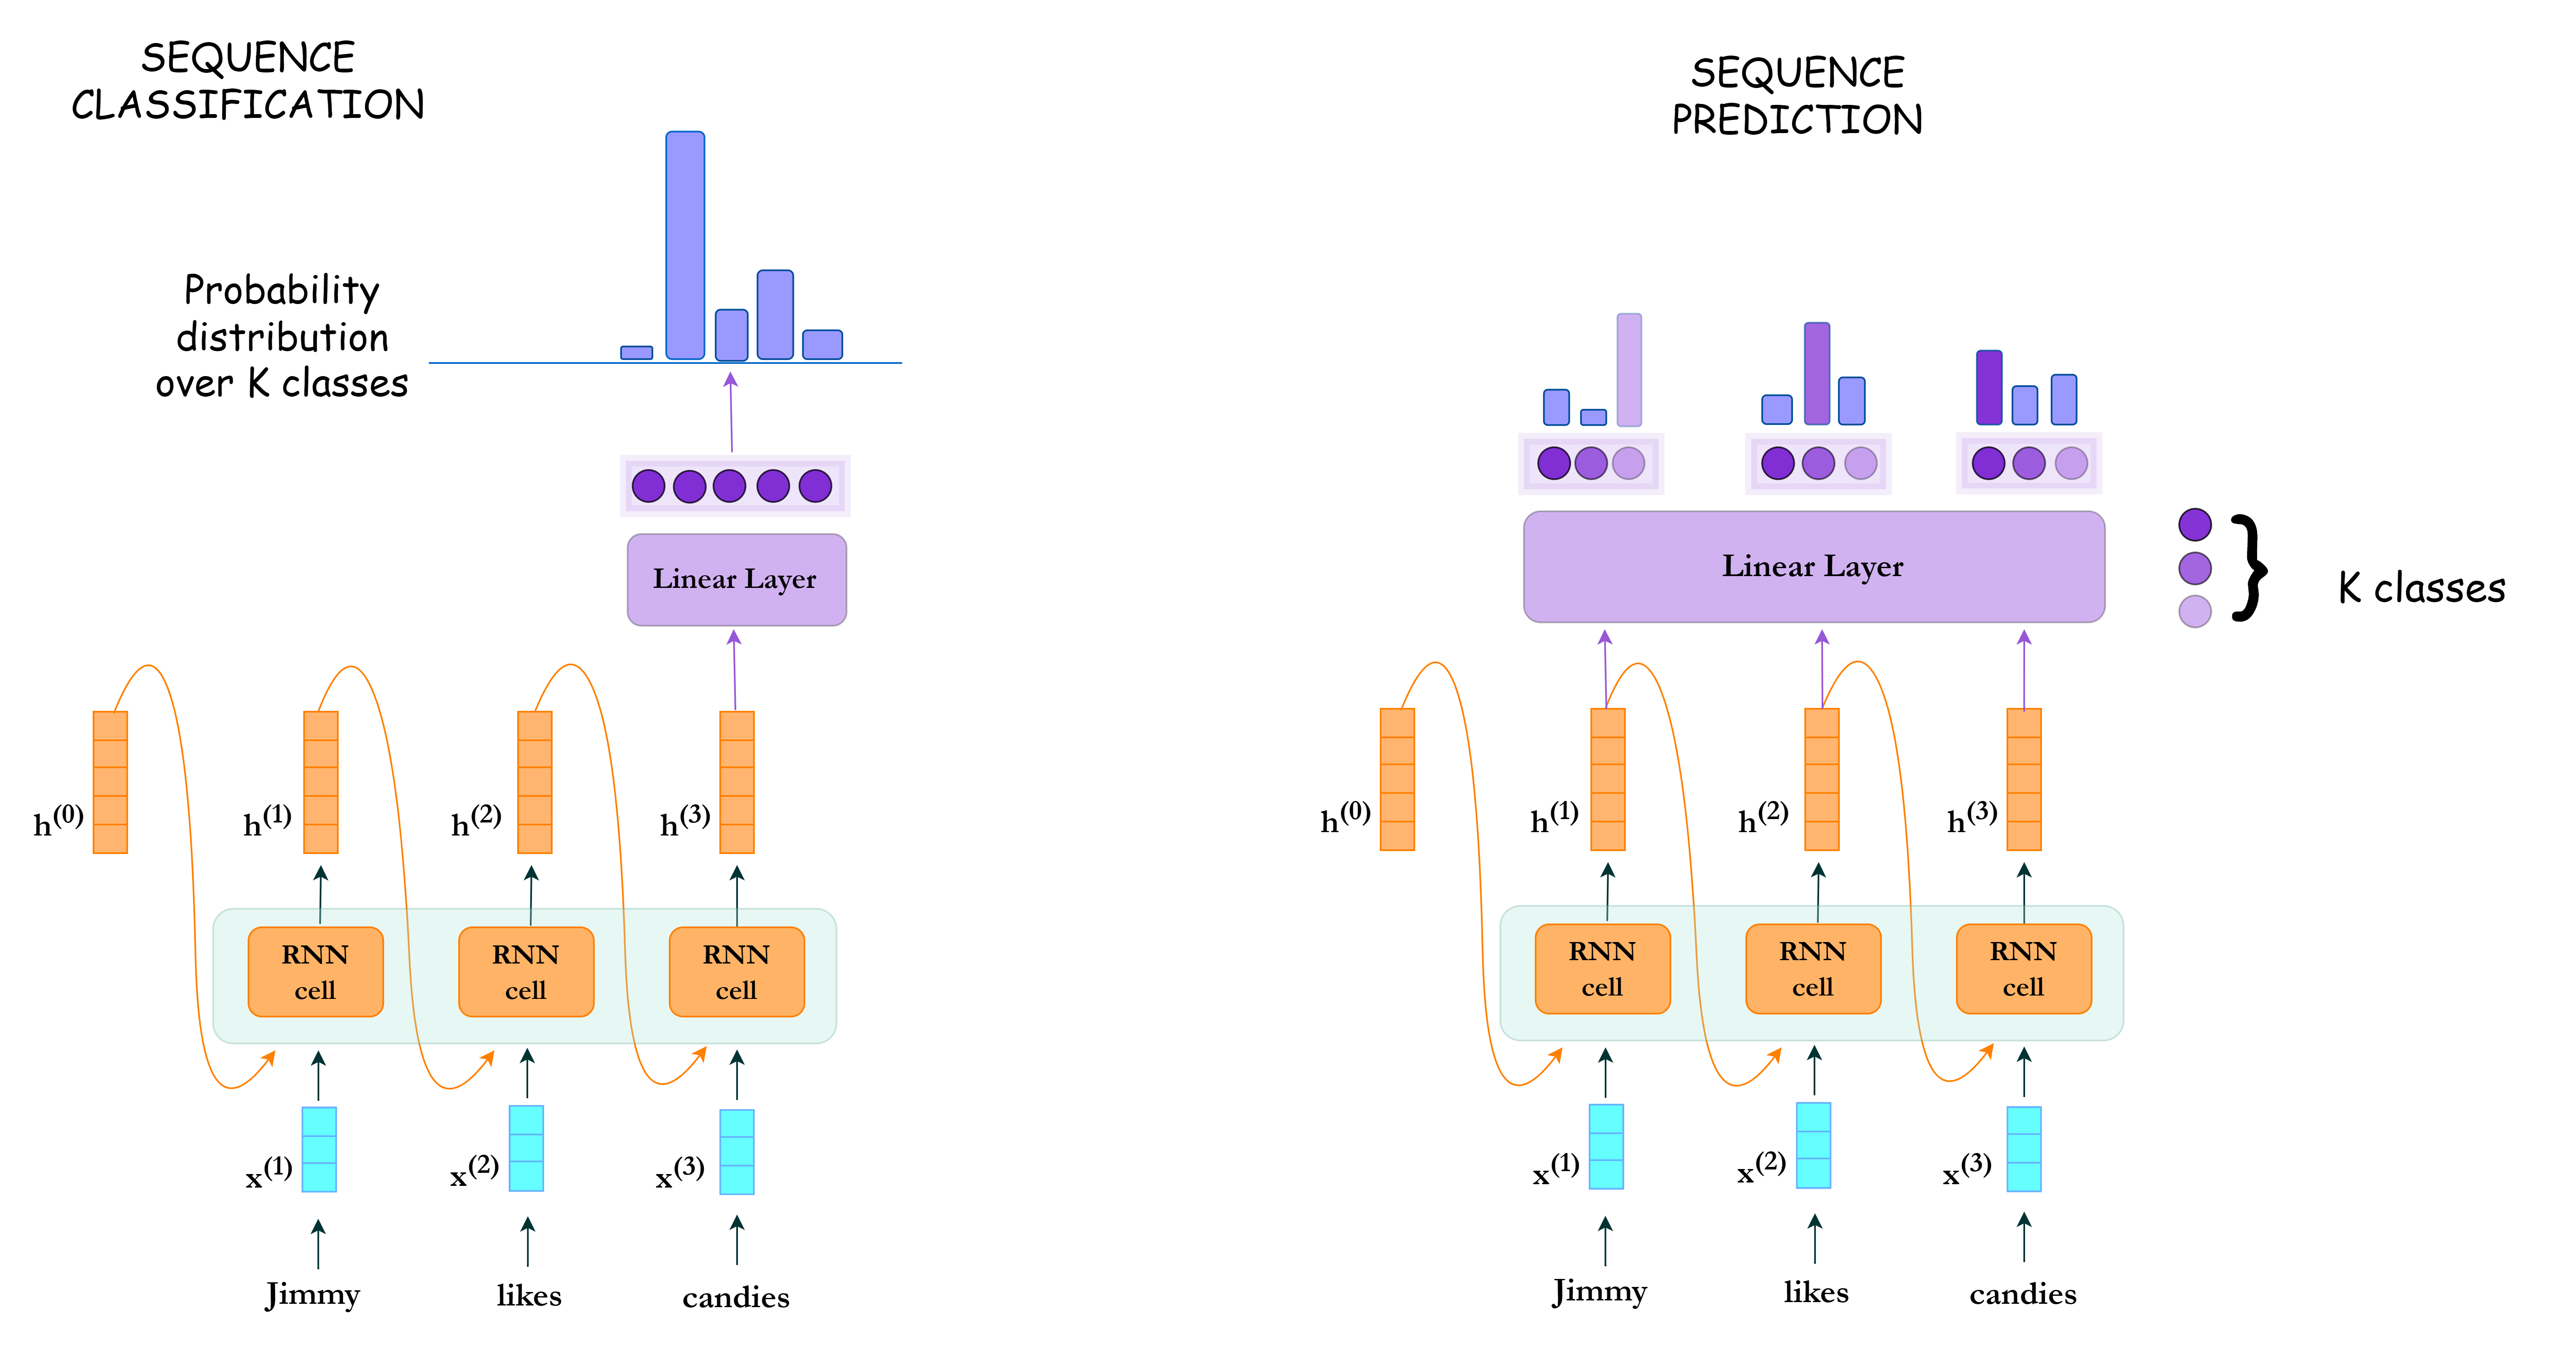

## <h3 style="text-align: center;"><b>Sequence classification</b>

Build RNN sequence model to classify Yelp restaurant reviews as positive or negative.

In [12]:
# import datasets
import pandas as pd
yelp = pd.read_csv(r"D:\Huawei Share\Download\reviews_with_splits_lite.csv")
yelp.head()

,rating,review,split
0,negative,terrible place to work for i just heard a stor...,train
1,negative,"hours , minutes total time for an extremely s...",train
2,negative,my less than stellar review is for service . w...,train
3,negative,i m granting one star because there s no way t...,train
4,negative,the food here is mediocre at best . i went aft...,train


In [205]:
yelp.split.value_counts()

train    39200
val       8400
test      8400
Name: split, dtype: int64

In [13]:
train_dataset = yelp[yelp.split=="train"]
valid_dataset = yelp[yelp.split=="val"]
test_dataset = yelp[yelp.split=="test"]

## <h6 style="text-align: center;"><b>Prepare data for training RNN</b>

1. build a vocabulary mapping unique tokens into integers
2. create a Dataset class to access vectorized training examples
3. group and pad training examples into minibatches for efficient training

In [14]:
import re
from torchtext.vocab import vocab
from collections import Counter, OrderedDict, defaultdict

## <h6 style="text-align: center;"><b>STEP 1. Build vocabularies</b>

In [46]:
def tokenize(text):
    clean_text = re.sub("[\W]+", " ", text.lower().replace("-", " "))
    return clean_text.split()

In [47]:
token_counter = Counter()
for index, row in train_dataset.iterrows():
    label, review = row.rating, row.review
    tokens = tokenize(review)
    token_counter.update(tokens)
    
sorted_tuples = token_counter.most_common()
vocabulary = vocab(OrderedDict(sorted_tuples), min_freq=2, specials = ["<pad>", "<unk>", "<bos>", "<eos>"])
pad_index = vocabulary["<pad>"]
unk_index = vocabulary["<unk>"]
vocabulary.set_default_index(unk_index) # tokens not seen in training data will be assigned 1 by default
len(vocabulary)

30931

* **\<unk\>**  is a reserved token for Out-Of-Vocabulary words, that did not occur in the training dataset
* **\<pad\>** serves as a placeholder for adjusting the length of shorter sequences when batching sequences together
* **\<bos\>** and **\<eos\>** are helpful in sequence modeling to indicate sentence boundaries to the model

In [17]:
# Illustrating the usage of vocabulary to convert words into indices

print([vocabulary[token] for token in "i found the plot intriguing".split()])

[6, 246, 4, 17903, 13943]


Create a dictionary mapping for labels too.

In [48]:
label2index = {label: index for index, label in enumerate(list(train_dataset.rating.unique()))}
label2index

{'negative': 0, 'positive': 1}

## <h6 style="text-align: center;"><b>STEP 2. Vectorize sequences</b>

Create a class to allow an easy access to training examples.

In [49]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    
    """ Converts sequences of words into sequences of integers, 
        and labels of negative and positive into 0 and 1. """
    
    def __init__(self, dataframe, vocabulary, label2index):
        self.data = dataframe
        self.voc = vocabulary
        self.lab2idx = label2index
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        review, label = row.review, row.rating
        vectorized_review = [self.voc[token] for token in tokenize(row.review)]
        label_index = self.lab2idx[label]
        
        return torch.LongTensor(vectorized_review), label_index

In [50]:
training_data = CustomDataset(train_dataset, vocabulary, label2index)
validation_data = CustomDataset(valid_dataset, vocabulary, label2index)

print("Review:\n", train_dataset.iloc[1].review)
print("Vectorized review:\n", training_data[1][0], "\nlabel id:", training_data[1][1])

Review:
  hours , minutes total time for an extremely simple physical . stay away unless you have hours to waste ! ! ! 
Vectorized review:
 tensor([ 341,  135,  735,   51,   12,   66,  490,  670, 3880,  422,  225,  743,
          20,   26,  341,    7,  850]) 
label id: 0


## <h6 style="text-align: center;"><b>STEP 3. Pad and Batchify</b>

To store a batch of sequences in a tensor, we need to make sure that all sequences in a batch are of the same length.\
PyTorch provides ``pad_sequence()`` method to pad shorter sequences to the length of the longest sequence in a batch.\
We can apply further preprocessing (like padding) of sequences that are collected in a batch inside ``collate_batch`` function.\
The function will be used by dataloader to collate training examples into batches.

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [54]:
def collate_batch(list_samples):
    
    seq_list, label_list, seq_lengths = [], [], []
    for sequence, label in list_samples:
        
        if len(sequence)<1:
            continue
        seq_list.append(sequence)
        seq_lengths.append(len(sequence))
        label_list.append(label)
        
    label_list = torch.tensor(label_list).float()
    seq_lengths = torch.tensor(seq_lengths)
    padded_sequences = nn.utils.rnn.pad_sequence(seq_list, batch_first=True)
    return padded_sequences.to(device), seq_lengths, label_list.to(device)

In [40]:
# Illustrating how padding works

dataloader = DataLoader(training_data, shuffle=True, batch_size = 4, collate_fn=collate_batch)
seq_batch, len_batch, label_batch = next(iter(dataloader))
seq_batch, len_batch, label_batch

(tensor([[    4,   365,    37,  ...,     0,     0,     0],
         [    6,   299,   422,  ...,     0,     0,     0],
         [   24,   116,     7,  ...,     0,     0,     0],
         [ 1459,    19,  4831,  ...,    38, 15254,  1013]], device='cuda:0'),
 tensor([118, 121, 254, 375]),
 tensor([0., 1., 1., 0.], device='cuda:0'))

In [55]:
batch_size = 32
train_dl = DataLoader(training_data, shuffle=True, batch_size=batch_size, collate_fn=collate_batch)
valid_dl = DataLoader(validation_data, shuffle=False, batch_size=batch_size, collate_fn=collate_batch)

Now the data is ready for an RNN model!

## <h6 style="text-align: center;"><b>Building RNN model</b>

* **embedding layer** embeds each word index into a feature vector of dimensionality equal to embed_dim
* **recurrent layer** produces sequence representation, encoded in the final hidden state
* **fully connected layer** returns a single output value as the model prediction

In [30]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, seq_batch, seq_lengths):
        emb = self.embedding(seq_batch)
        
        # packed_sequences shape: (batch_size*seq_len, embed_dim)
        packed_sequences = nn.utils.rnn.pack_padded_sequence(emb,
                                                             seq_lengths.cpu().numpy(),
                                                             enforce_sorted=False,
                                                             batch_first=True)
        
        # rnn_hiddens is PackedSequence .data shape:(batch_size*seq_len, hidden_size)
        # last_hidden shape: (1, batch_size, hidden_size)
        rnn_hiddens, last_hidden = self.rnn(packed_sequences)
        
        # output shape: (1, batch_size, hidden_dim)
        output = self.relu(self.fc1(last_hidden))
        # output shape: (1, batch_size, 1)
        output = self.sigmoid(self.fc2(output))
        return output.view(-1)

In [101]:
vocab_size = len(vocabulary)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model.to(device)
model

RNN(
  (embedding): Embedding(30931, 20, padding_idx=0)
  (rnn): GRU(20, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [34]:
def train(dataloader):
    model.train()
    epoch_acc, epoch_loss = 0, 0
    for seq_batch, seq_lengths, label_batch in dataloader:
        # step 1. remove  current gradients
        optimizer.zero_grad()
        # step 2. predict the probability of label 1:positive
        prediction = model(seq_batch, seq_lengths) 
        # step 3. compute prediction error
        loss = loss_function(prediction, label_batch)
        # step 4. compute gradients
        loss.backward()
        # step 5. update model parameters
        optimizer.step()
        # step 6.reporting
        epoch_loss += loss.item()*label_batch.size(0)
        epoch_acc += ((prediction >= 0.5).float() == label_batch).float().sum().item()
    return epoch_loss/len(dataloader.dataset), epoch_acc/len(dataloader.dataset)

def evaluate(dataloader):
    model.eval()
    epoch_acc, epoch_loss = 0, 0
    with torch.no_grad():
        for seq_batch, seq_lengths, label_batch in dataloader:
            prediction = model(seq_batch, seq_lengths) 
            loss = loss_function(prediction, label_batch)
            epoch_loss += loss.item()*label_batch.size(0)
            epoch_acc += ((prediction >= 0.5).float() == label_batch).float().sum().item()
    return epoch_loss/len(dataloader.dataset), epoch_acc/len(dataloader.dataset)

Given that the model output is the probability of class 1 (positive), we use the binary cross-entropy loss function.

In [102]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## <h6 style="text-align: center;"><b>Training RNN model</b>

In [90]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

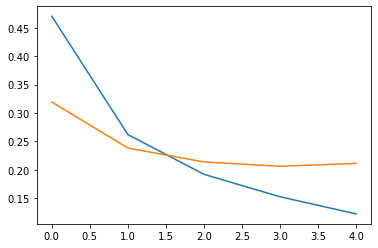

Epoch 4 accuracy: 0.954 val_accuracy: 0.922


In [103]:
num_epochs = 5
torch.manual_seed(1)

train_dict = defaultdict(list)
for epoch in range(num_epochs):
    loss_train, acc_train = train(train_dl)
    loss_valid, acc_valid = evaluate(valid_dl)
    train_dict["train_loss"].append(loss_train)
    train_dict["valid_loss"].append(loss_valid)

    clear_output()
    plt.plot(train_dict["train_loss"], label="training loss")
    plt.plot(train_dict["valid_loss"], label="validation loss")
    plt.show()
    
    print(f"Epoch {epoch} accuracy: {acc_train:.3f} "
          f"val_accuracy: {acc_valid:.3f}")

In [104]:
def predict_sentiment(review):
    model.eval()
    tokens = tokenize(review)
    with torch.no_grad():
        vectorized_review = torch.LongTensor([vocabulary[token] for token in tokens]).to(device)
        pred_probability = model(vectorized_review.unsqueeze(0), torch.tensor([len(vectorized_review)]))
    return "positive" if pred_probability.item() >= 0.5 else "negative"

In [117]:
sample = 61
print(test_dataset.iloc[sample].review)
print(test_dataset.iloc[sample].rating)
print(predict_sentiment(test_dataset.iloc[sample].review))

i am a longtime shopper at buffalo exchange and i must say , this location is terrible . staff is unfriendly , selection is awful they never seem to buy any of the quality clothing that i bring in . i am done shopping here , completely over it . 
negative
negative


Evaluate the model performance on held-out dataset.

In [ ]:
acc_test, _  = evaluate(test_dl)
print(f"test_accuracy: {acc_valid}")